In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

pd.set_option('max_columns', None)

In [23]:
os.listdir()

['regression_model',
 '.DS_Store',
 'MarathonData.csv',
 'Results.png',
 'marathon_prediction_time.ipynb',
 'README.md',
 '.ipynb_checkpoints',
 '.git',
 '.idea']

# Exploratory Data Analysis

In [29]:
df = pd.read_csv('MarathonData.csv')
train, test = train_test_split(df, test_size=0.25, random_state=42)
train.to_csv("train.csv")
test.to_csv("test.csv")


In [4]:
df.head()

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,NaN,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.5,12.258544,NaN,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.6,13.945055,NaN,1.36,2.74,A


In [5]:
df.tail()

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
82,83,Prague17,Stefano Vegliani,M55,50.0,10.830325,NaN,2.02,3.93,D
83,84,Prague17,Andrej Madliak,M40,33.6,10.130653,ciclista 3h,1.94,3.93,D
84,85,Prague17,Yoi Ohsako,M40,55.4,11.043189,NaN,1.94,3.94,D
85,86,Prague17,Simon Dunn,M45,33.2,11.066667,NaN,2.05,3.95,D
86,87,Prague17,Pavel ?imek,M40,17.9,10.848485,ciclista 5h,2.05,3.98,D


In [6]:
df.shape

(87, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             87 non-null     int64  
 1   Marathon       87 non-null     object 
 2   Name           87 non-null     object 
 3   Category       81 non-null     object 
 4   km4week        87 non-null     float64
 5   sp4week        87 non-null     float64
 6   CrossTraining  13 non-null     object 
 7   Wall21         87 non-null     object 
 8   MarathonTime   87 non-null     float64
 9   CATEGORY       87 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 6.9+ KB


In [8]:
df.describe()

,id,km4week,sp4week,MarathonTime
count,87.000000,87.000000,87.000000,87.000000
mean,44.000000,62.347126,139.840706,3.319080
std,25.258662,26.956019,1191.427864,0.376923
min,1.000000,17.900000,8.031414,2.370000
25%,22.500000,44.200000,11.498168,3.045000
50%,44.000000,58.800000,12.163424,3.320000
75%,65.500000,77.500000,12.854036,3.605000
max,87.000000,137.500000,11125.000000,3.980000


I drop 
* **id columns**:
    * such as id of the runner
    * marathon name 
    * name of the runner
* **data that is obtained after the race**: 
    * Wall21 is the time in the race when the runnes does the half marathon
    * Category is a bin variable of the Marathon time

In [9]:
to_drop = ['id', 'Marathon', 'Name', 'Wall21', 'CATEGORY']
df.drop(to_drop, axis = 1, inplace = True)

## Numerical data

### Histograms

In [10]:
num_vars = [var for var in df.columns if df[var].dtype != 'O']
num_vars

['km4week', 'sp4week', 'MarathonTime']

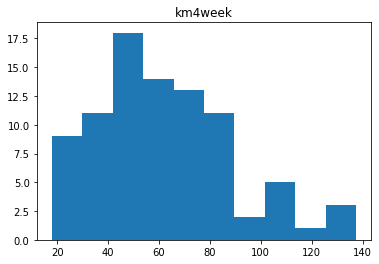

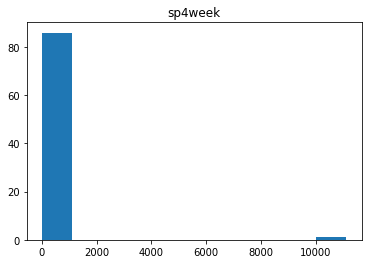

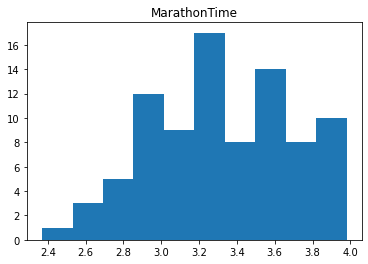

In [11]:
def plot_distribution(df, var):
    plt.figure(figsize=(6,4))
    plt.hist(df[var])
    plt.title(var)
    plt.show()
    
for var in num_vars:
    plot_distribution(df, var)

Clearly there is an outlier in sp4week variable. Let's remove it

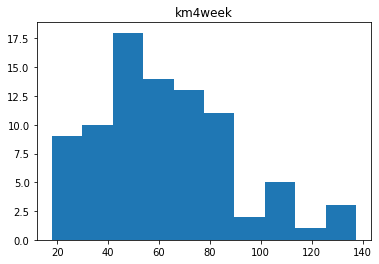

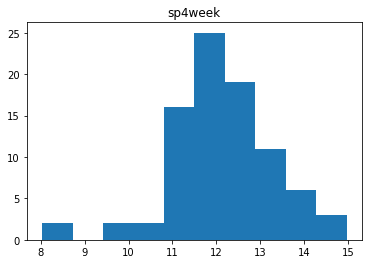

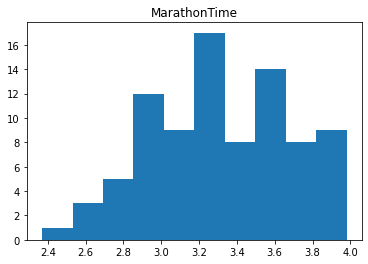

In [12]:
df = df[df['sp4week'] <= 10000]


for var in num_vars:
    plot_distribution(df, var)

### Relation with target

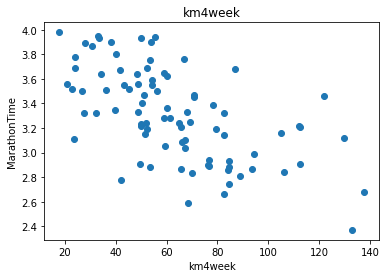

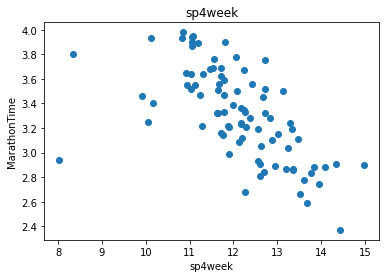

In [13]:
def plot_scatter(df, var):
    plt.figure(figsize=(6,4))
    plt.scatter(df[var], df['MarathonTime'])
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('MarathonTime')
    plt.show()

for var in num_vars:
    if var != 'MarathonTime':
        plot_scatter(df, var)

## Categorical Data

In [14]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
cat_vars

['Category', 'CrossTraining']

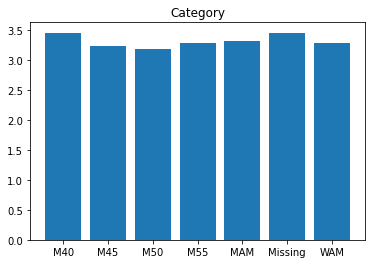

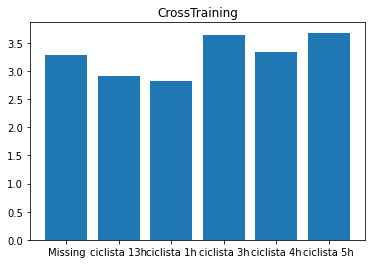

In [15]:
def plot_categorical_data(data, var):
    df = data.copy()
    df[var] = df[var].fillna('Missing')
    temp = df.groupby(var).median().sort_values(var, ascending=True)
    plt.figure(figsize=(6,4))
    plt.bar(x=temp.index, height=temp['MarathonTime'])
    plt.title(var)
    plt.show()

for var in cat_vars:
    plot_categorical_data(df, var)

# Feature Engineering

In [16]:
df = pd.read_csv('MarathonData.csv')

In [17]:
to_drop = ['id', 'Marathon', 'Name', 'Wall21', 'CATEGORY']
df.drop(to_drop, axis = 1, inplace = True)
df = df[df['sp4week']<=5000]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    df['MarathonTime'],
                                                    test_size=0.25,
                                                    random_state=42)

X_train = pd.DataFrame(X_train,
                       columns = df.columns)

X_test = pd.DataFrame(X_test,
                      columns = df.columns)

X_train.shape, X_test.shape

((64, 5), (22, 5))

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 40 to 51
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Category       60 non-null     object 
 1   km4week        64 non-null     float64
 2   sp4week        64 non-null     float64
 3   CrossTraining  9 non-null      object 
 4   MarathonTime   64 non-null     float64
dtypes: float64(3), object(2)
memory usage: 3.0+ KB


In [30]:
X_train.columns

Index(['Category', 'km4week', 'sp4week', 'CrossTraining', 'MarathonTime'], dtype='object')

Only categorical data has missing values

# Missing Values

In [20]:
vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

X_train[vars_with_na].isnull().mean()

Category         0.062500
CrossTraining    0.859375
dtype: float64

In [ ]:
X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [ ]:
# check that test set does not contain null values in the engineered variables
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

# Categocial encoder

In [21]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['Category', 'CrossTraining']

In [31]:
def find_frequent_labels(df, var, rare_perc):

    df = df.copy()

    tmp = df.groupby(var)['MarathonTime'].count() / len(df)

    return tmp[tmp > rare_perc].index

for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [32]:
X_test

,Category,km4week,sp4week,CrossTraining,MarathonTime
75,MAM,23.9,12.050420,Rare,3.78
0,MAM,132.8,14.434783,Rare,2.37
70,M45,87.0,11.472527,Rare,3.68
22,M40,59.4,12.638298,Rare,3.05
12,M45,53.5,14.078947,Rare,2.88
56,MAM,56.2,12.086022,Rare,3.50
10,MAM,93.5,13.200000,Rare,2.87
18,MAM,84.5,12.549505,Rare,2.93
4,MAM,84.6,13.945055,Rare,2.74
67,MAM,34.3,11.307692,Rare,3.64


In [33]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the lower
# median Marathon Time


def replace_categories(train, test, var, target):

    # order the categories in a variable from that with the lowest
    # marathon time, to that with the highest
    ordered_labels = train.groupby([var])[target].median().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [34]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'MarathonTime')

In [35]:
X_test

,Category,km4week,sp4week,CrossTraining,MarathonTime
75,2,23.9,12.050420,0,3.78
0,2,132.8,14.434783,0,2.37
70,0,87.0,11.472527,0,3.68
22,3,59.4,12.638298,0,3.05
12,0,53.5,14.078947,0,2.88
56,2,56.2,12.086022,0,3.50
10,2,93.5,13.200000,0,2.87
18,2,84.5,12.549505,0,2.93
4,2,84.6,13.945055,0,2.74
67,2,34.3,11.307692,0,3.64


In [36]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [37]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

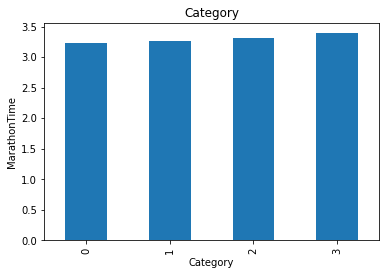

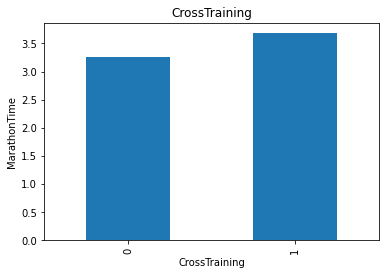

In [38]:
def analyse_vars(df, var):
    
    # function plots median marathon time per encoded
    # category
    
    df = df.copy()
    df.groupby(var)['MarathonTime'].median().plot.bar()
    plt.title(var)
    plt.ylabel('MarathonTime')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

# Numerical variables

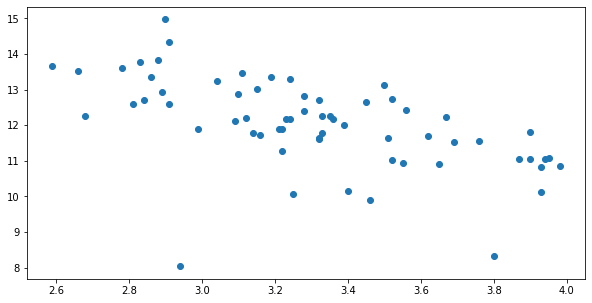

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(x=X_train['MarathonTime'], y=X_train['sp4week'])
plt.show()

In [40]:
X_train

,Category,km4week,sp4week,CrossTraining,MarathonTime
40,0,61.3,12.383838,0,3.28
28,0,51.6,13.008403,0,3.15
9,0,84.2,13.365079,0,2.86
65,0,60.3,11.708738,0,3.62
5,3,42.2,13.612903,0,2.78
...,...,...,...,...,...
20,2,94.5,11.886792,0,2.99
60,3,43.2,10.936709,0,3.55
71,1,24.2,11.523810,0,3.69
14,2,76.8,12.943820,0,2.89


In [41]:
X_test

,Category,km4week,sp4week,CrossTraining,MarathonTime
75,2,23.9,12.050420,0,3.78
0,2,132.8,14.434783,0,2.37
70,0,87.0,11.472527,0,3.68
22,3,59.4,12.638298,0,3.05
12,0,53.5,14.078947,0,2.88
56,2,56.2,12.086022,0,3.50
10,2,93.5,13.200000,0,2.87
18,2,84.5,12.549505,0,2.93
4,2,84.6,13.945055,0,2.74
67,2,34.3,11.307692,0,3.64


# Model fitting

In [42]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf = GridSearchCV(regr, parameters)
X_train.drop('MarathonTime', axis=1, inplace=True)
X_test.drop('MarathonTime', axis=1, inplace=True)
clf.fit(X_train, y_train)

/Users/carloscliment/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/carloscliment/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4],
  

In [46]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
y_pred_train = clf.predict(X_train)
mean_squared_error(y_train, y_pred_train)

In [ ]:
y_pred = clf.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", sqrt(mean_squared_error(y_test, y_pred)))

Basically, the error we have on average per prediction is 0.22 hours, which is less than 15 minutes.

In [ ]:
results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
results.head(10)

In [ ]:
results['error'].hist()

In [ ]:
plt.figure(figsize=(10,10))
x=np.linspace(0,5,5)
plt.plot(results['y_test'], results['y_pred'], 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,4)
plt.ylim(2.25,4)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()